# Where should I eat after the pandemic? (Part 1/2)
## Using Transformers for Decision Making with Aspect-Based Sentiment Analysis.

**Make sure to switch to a GPU enabled runtime!**



In [ ]:
!pip install transformers
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip


In [ ]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torchvision
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from tqdm.autonotebook import tqdm
from torch.utils.data.sampler import WeightedRandomSampler

In [ ]:
def preprocess(bs: BeautifulSoup) -> List[dict]:

    data = []

    for s in bs.find_all("sentence"):
        sid = s.get("id")
        s1 = s.find_all("text")[0].contents[0]

        records = []

        categories = ["food", "service", "price", "ambience", "anecdotes"]

        labels = {c: "none" for c in categories}

        for ac in s.find_all("aspectcategory"):
            category = ac.get("category")
            polarity = ac.get("polarity")

            if category.startswith("anecdotes"):
                category = "anecdotes"

            labels[category] = polarity

        records = 5*[None]
        for i, (c, label) in enumerate(labels.items()):
            data += [{
                "sentence_id": sid,
                "s1": s1,
                "s2": c,
                "label": label
            }]

    return data


def load_data(model_name: str):
    base_url = "https://raw.githubusercontent.com/mwbrulhardt/yelp-absa/main/data/semeval2014"
    bs_train = BeautifulSoup(requests.get(base_url + "/Restaurants_Train.xml").content)
    bs_test = BeautifulSoup(requests.get(base_url + "/Restaurants_Test_Gold.xml").content)
    
    frames = {
        "train": pd.DataFrame(preprocess(bs_train)),
        "test": pd.DataFrame(preprocess(bs_test))
    }

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    labels = ["none", "negative", "neutral", "positive", "conflict"]
    label_map = {label: i for (i, label) in enumerate(labels)}

    datasets = {
        "train": None,
        "test": None
    }

    for k in datasets:
        data = frames[k]
        labels = list(data.label.apply(lambda x: label_map[x]))

        encoded = tokenizer(
            list(data.s1),
            list(data.s2),
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        datasets[k] = torch.utils.data.TensorDataset(
            encoded["input_ids"],
            encoded["attention_mask"],
            torch.tensor(labels, dtype=torch.long).reshape(-1, 1)
        )

    return datasets["train"], datasets["test"]


def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

## Train

In [ ]:
def acc(confusion: np.array) -> float:
    return confusion.trace() / confusion.sum().sum()


def mcc(confusion: np.array) -> float:
    t = confusion.sum(0)
    p = confusion.sum(1)
    c = confusion.trace()
    s = confusion.sum().sum()

    num = c*s - t.dot(p)
    den = np.sqrt(s**2 - p.dot(p))*np.sqrt(s**2 - t.dot(t))

    return num / den


def train_absa(config: dict, balanced_classes=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_id = config["model_id"]

    num_labels = len(config["labels"])
    numeric_labels = list(range(num_labels))

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)
    model.train()
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=config["lr"]
    )

    train_set, test_set = load_data(model_id)

    cutoff = int(0.8 * len(train_set))
    train_subset, val_subset = random_split(train_set, [cutoff, len(train_set) - cutoff])

    sampler = None

    if balanced_classes:
      class_labels = [el[2].numpy()[0] for el in train_subset]
      class_sample_count = np.array(
      [len(np.where(class_labels == t)[0]) for t in np.unique(class_labels)])
      weight = 1. / class_sample_count
      samples_weight = np.array([weight[t] for t in class_labels])
      samples_weight = torch.from_numpy(samples_weight)
      samples_weight = samples_weight.double()
      sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True if sampler is None else False,
        sampler=sampler
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )

    # Train
    total = (cutoff // config["batch_size"]) + int(cutoff % config["batch_size"] != 0)

    for epoch in range(config["epochs"]):

        for i, (input_ids, attention_mask, labels) in tqdm(enumerate(train_loader), total=total):
          
            optimizer.zero_grad()

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss = output["loss"]

            loss.backward()
            optimizer.step()

        # Validation
        running_loss = 0.0
        steps = 0
        confusion = np.zeros([num_labels, num_labels])

        for i, (input_ids, attention_mask, labels) in enumerate(val_loader):

            with torch.no_grad():

                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    labels=labels.to(device)
                )
                loss, logits = output["loss"], output["logits"]

                confusion += confusion_matrix(
                    y_true=labels.flatten().cpu(), 
                    y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                    labels=numeric_labels
                )

                running_loss += loss.cpu().numpy()
                steps += 1

        summary = dict(
            loss=(running_loss / steps),
            accuracy=acc(confusion),
            mcc=mcc(confusion)
        )
        print(summary)


    torch.save(model, f"./absa-{model_id.replace('/', '_')}.pt")
    print("Finished training.")

    return model

In [ ]:
configs = [
    {
        "model_id": "prajjwal1/bert-tiny",
        "model_name": "bert-tiny",
        "epochs": 15,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "prajjwal1/bert-small",
        "model_name": "bert-small",
        "epochs": 10,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "distilbert-base-uncased",
        "model_name": "distilbert",
        "epochs": 4,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "bert-base-uncased",
        "model_name": "bert",
        "epochs": 4,
        "batch_size": 24,
        "lr": 2e-5
    }
]

config = configs[2]
config["labels"] = ["none", "negative", "neutral", "positive", "conflict"]

In [ ]:
model = train_absa(config, balanced_classes=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

  0%|          | 0/508 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Evaluate

In [ ]:
def evaluate(model, ds, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels = len(config["labels"])
    numeric_labels = list(range(num_labels))

    test_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    model.eval()

    test_loss = 0
    test_steps = 0
    confusion = np.zeros([num_labels, num_labels])

    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):

        with torch.no_grad():

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss, logits = output["loss"], output["logits"]

            confusion += confusion_matrix(
                y_true=labels.flatten().cpu(), 
                y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                labels=numeric_labels
            )

            test_loss += loss.cpu().numpy()
            test_steps += 1

    print("Test Results:")
    summary = dict(
        model=config["model_name"],
        loss=(test_loss / test_steps),
        accuracy=acc(confusion),
        mcc=mcc(confusion)
    )
    print(summary)

    return summary, confusion

In [ ]:
model = torch.load(f"absa-{config['model_id'].replace('/', '_')}.pt")
train_set, test_set = load_data(config["model_id"])

summary, confusion = evaluate(model, test_set, config)

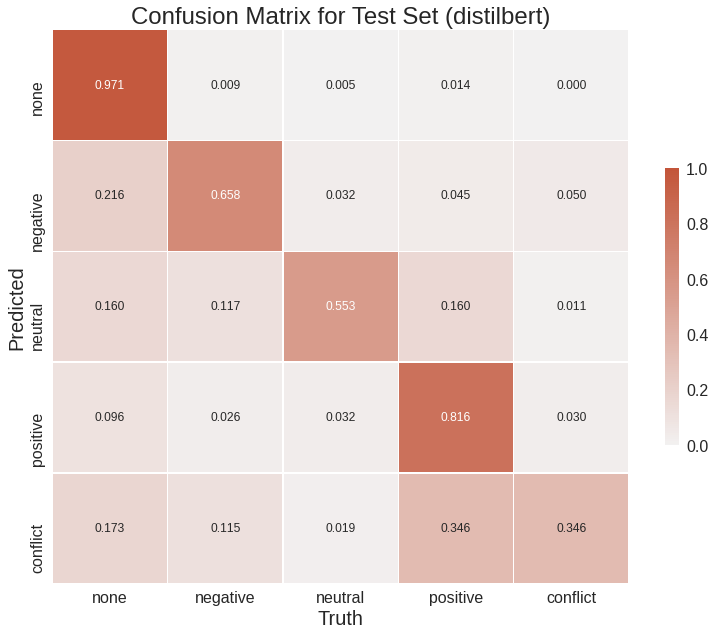

In [ ]:
sns.set_theme(style="white")
plt.style.use("seaborn")
plt.rcParams.update({
    "figure.titlesize": 30,
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.title_fontsize": 20,
    "legend.fontsize": 16
})

labels = ["none", "negative", "neutral", "positive", "conflict"]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

X = confusion / confusion.sum(1, keepdims=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    pd.DataFrame(X, index=labels, columns=labels), 
    cmap=cmap, 
    center=0,
    vmin=0,
    vmax=1,
    annot=True, 
    fmt=".3f",
    linewidths=.5, 
    cbar_kws={
        "shrink": .5
    }
)
ax.set_title("Confusion Matrix for Test Set (distilbert)")
ax.set_xlabel("Truth")
ax.set_ylabel("Predicted")
plt.tight_layout()
plt.show()

## Examples

In [ ]:
class SentimentAnalyzer:

    def __init__(self, model, model_name):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.aspects = ["food", "service", "price", "ambience", "anecdotes"]
        self.labels = ["none", "negative", "neutral", "positive", "conflict"]

    def __call__(self, text: str) -> dict:

        encoded = self.tokenizer(
            5*[text],
            self.aspects,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            input_ids = encoded["input_ids"].to(self.device)
            attention_mask = encoded["attention_mask"].to(self.device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = output["logits"]

            predicted = torch.softmax(logits, -1).argmax(-1)
            y_pred = predicted.cpu()

        return {a: self.labels[y_pred[i]] for i, a in enumerate(self.aspects)}

absa = SentimentAnalyzer(model, config["model_id"])

In [ ]:
samples = [
    "We had a good time at the restaurant.",
    "We had a good time at the restaurant. The food was delicious.",
    "The waiter we had was horrible, but the food was amazing.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. The food here was disgusting and the service was even worse. I will never in my life go back to this pizzeria.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. The atmosphere was nice, but the food here was disgusting and the service was even worse. I will never in my life go back to this pizzeria.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. Nevermind how expensive it was, the food was horrible and staff was very rude. The only redeeming quality was that the atmosphere was nice, however, I will never in my life go back to this pizzeria.",
    "Nevermind how expensive it was, the food was horrible and staff was very rude."
]

pd.DataFrame([absa(s) for s in samples])